In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve,precision_recall_curve,auc  # Import metrics
import shap
import pickle
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('1_prep_data.csv')
data.shape

(9997, 13)

In [3]:
data.Exited.value_counts()

Exited
0    7960
1    2037
Name: count, dtype: int64

In [4]:
# x_test.columns

In [5]:
from sklearn.model_selection import train_test_split
y = data['Exited']
X = data.drop(['Exited','Age','CreditScore','CustomerId','CreditScore_Custom'],axis=1)
X['is_zero_balance'] = np.where(X.Balance == 0,1,0)
cat_variables =  [col for col in X.columns if X[col].dtype == 'O']
other_variables = list(set(X.columns.to_list()) - set(cat_variables))

final_cols = cat_variables+other_variables
X = X[final_cols]
print(X.columns)

primary_key = data['CustomerId']
x_train, x_temp, y_train, y_temp,test_primary_key,temp_primary_key = train_test_split(X, y,primary_key, test_size=0.2, random_state=42, stratify=y)

x_test, x_oos, y_test, y_oos,test_primary_key,oos_primary_key = train_test_split(x_temp, y_temp,temp_primary_key, test_size=0.5, random_state=42, stratify=y_temp)

# Now you have your three datasets:
print(f"Training set size: X_train={x_train.shape}, y_train={y_train.shape}")
print(f"Testing set size: X_test={x_test.shape}, y_test={y_test.shape}")
print(f"Out-of-sample set size: X_oos={x_oos.shape}, y_oos={y_oos.shape}")

Index(['Geography', 'Gender', 'Age_Group_Custom', 'is_zero_balance', 'Balance',
       'EstimatedSalary', 'Tenure', 'IsActiveMember', 'NumOfProducts'],
      dtype='object')
Training set size: X_train=(7997, 9), y_train=(7997,)
Testing set size: X_test=(1000, 9), y_test=(1000,)
Out-of-sample set size: X_oos=(1000, 9), y_oos=(1000,)


In [6]:
x_train.shape

(7997, 9)

In [7]:
x_test.join(y_test).to_csv('x_test.csv',index  =False)

In [8]:
x_oos.join(y_oos).to_csv('x_oos.csv',index  =False)

In [9]:
x_test.shape

(1000, 9)

In [10]:
data['NumOfProducts'].value_counts()

NumOfProducts
1    5081
2    4590
3     266
4      60
Name: count, dtype: int64

In [11]:
numeric_columns = [col for col in x_train.columns if x_train[col].dtype != 'O' and col!='CustomerId']
numeric_columns
categorical_columns = [col for col in x_train.columns if x_train[col].dtype == 'O']
print(categorical_columns)

['Geography', 'Gender', 'Age_Group_Custom']


In [12]:
numeric_columns

['is_zero_balance',
 'Balance',
 'EstimatedSalary',
 'Tenure',
 'IsActiveMember',
 'NumOfProducts']

In [13]:
log_transform_cols = ['EstimatedSalary', 'Balance']
# log_transform_cols = numeric_columns

In [14]:
labels_endcode = ['Gender']
one_hot_labels = [val for val in categorical_columns if val not in labels_endcode]
print(labels_endcode,one_hot_labels)


['Gender'] ['Geography', 'Age_Group_Custom']


In [15]:
cat_variables =  [col for col in x_train.columns if x_train[col].dtype == 'O']
other_variables = list(set(x_train.columns.to_list()) - set(categorical_columns))

final_cols = cat_variables+other_variables
x_train = x_train[final_cols]
x_train.columns

Index(['Geography', 'Gender', 'Age_Group_Custom', 'is_zero_balance', 'Balance',
       'EstimatedSalary', 'Tenure', 'IsActiveMember', 'NumOfProducts'],
      dtype='object')

In [16]:
y_train.value_counts()

Exited
0    6368
1    1629
Name: count, dtype: int64

In [17]:
y_test.value_counts()

Exited
0    796
1    204
Name: count, dtype: int64

In [18]:
# --- 1. Define Preprocessing Steps ---

# --- 1.1.  Label Encoding ---
label_encode_processor = Pipeline(
    steps=[
         ("label_encoder", OrdinalEncoder()),
    ]
)

# --- 1.2. One-Hot Encoding ---
onehot_encode_processor = Pipeline(
    steps=[
        ("onehot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

# --- 1.3. Log Transformation ---
def log_transform(x):
    # Handle non-positive values by adding a small constant
    x_adjusted = np.where(x <= 0, 1e-6, x)
    return np.log(x_adjusted)

log_transform_processor = Pipeline(
    steps=[
        ("log_transformer", FunctionTransformer(log_transform)),
    ]
)
# --- 2.  Column Transformer ---
# Apply the different transformations to the specified columns
preprocessor = ColumnTransformer(
    transformers=[
        ("label_encode", label_encode_processor, labels_endcode),
        ("onehot_encode", onehot_encode_processor, one_hot_labels),
        ("log_transform", log_transform_processor, log_transform_cols),
    ],
    remainder="passthrough",  # Keep the remaining columns as is
)

# --- 3.  Pipeline ---
# Combine the preprocessor with optional missing value handling

positive_class_count = np.sum(y_train == 1)
negative_class_count = np.sum(y_train == 0)
scale_pos_weight = negative_class_count / positive_class_count

model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("model",CatBoostClassifier(scale_pos_weight=scale_pos_weight))])



In [19]:
cat_model = model_pipeline.fit(x_train,y_train)

Learning rate set to 0.025031
0:	learn: 0.6817023	total: 244ms	remaining: 4m 4s
1:	learn: 0.6701216	total: 259ms	remaining: 2m 9s
2:	learn: 0.6597630	total: 268ms	remaining: 1m 29s
3:	learn: 0.6495558	total: 277ms	remaining: 1m 8s
4:	learn: 0.6403864	total: 283ms	remaining: 56.4s
5:	learn: 0.6310736	total: 290ms	remaining: 48s
6:	learn: 0.6223509	total: 296ms	remaining: 42s
7:	learn: 0.6147099	total: 301ms	remaining: 37.3s
8:	learn: 0.6079332	total: 306ms	remaining: 33.7s
9:	learn: 0.6022077	total: 312ms	remaining: 30.9s
10:	learn: 0.5953029	total: 317ms	remaining: 28.5s
11:	learn: 0.5894878	total: 322ms	remaining: 26.5s
12:	learn: 0.5841773	total: 327ms	remaining: 24.9s
13:	learn: 0.5804135	total: 332ms	remaining: 23.4s
14:	learn: 0.5748259	total: 337ms	remaining: 22.1s
15:	learn: 0.5696454	total: 342ms	remaining: 21s
16:	learn: 0.5657422	total: 347ms	remaining: 20.1s
17:	learn: 0.5621009	total: 352ms	remaining: 19.2s
18:	learn: 0.5575820	total: 357ms	remaining: 18.4s
19:	learn: 0.553

In [20]:
y_pred = cat_model.predict(x_test)
y_prob = cat_model.predict_proba(x_test)[:,1]

results_df = pd.DataFrame(
    {"customer_id": test_primary_key, "prediction": y_pred, "actual": y_test}
)
# y_pred = np.where(y_prob > 0.5, 1, 0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"specificity: {specificity:.4f}")
# --- 13. Calculate and Print Performance Metrics ---
print("\n--- CatBoost Performance ---")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

cm = confusion_matrix(y_test,y_pred)
print(cm)

specificity: 0.8317

--- CatBoost Performance ---
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       796
           1       0.52      0.71      0.60       204

    accuracy                           0.81      1000
   macro avg       0.72      0.77      0.74      1000
weighted avg       0.84      0.81      0.82      1000

Accuracy: 0.8070
Precision: 0.5197
Recall: 0.7108
F1 Score: 0.6004
ROC AUC: 0.8535
[[662 134]
 [ 59 145]]


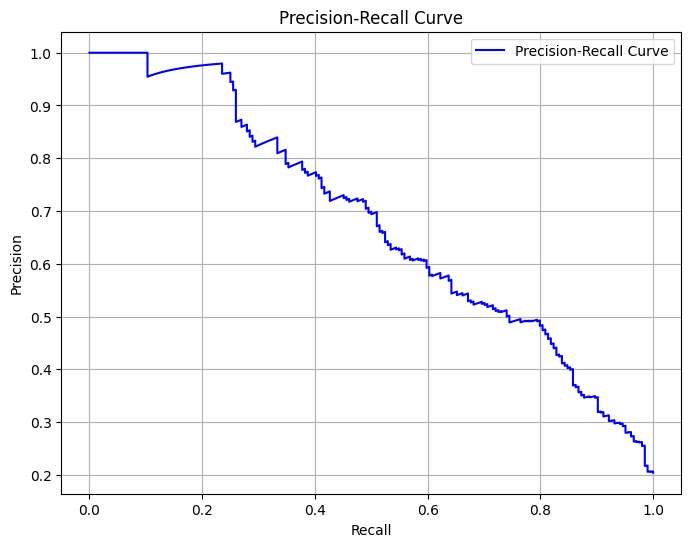

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
# 5. Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc='best')


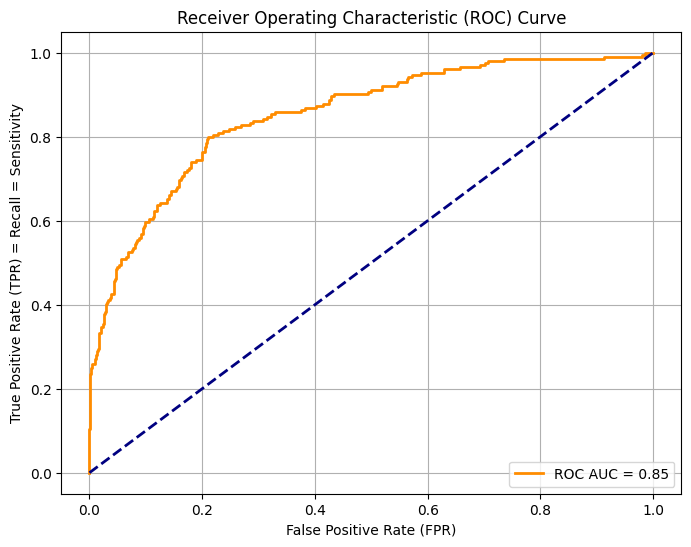

In [22]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) = Recall = Sensitivity')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [23]:

import pickle
filename = 'bank_churn_mod_v2.pkl'

# Open a file in binary write ('wb') mode
with open(filename, 'wb') as file:
    pickle.dump(cat_model, file)

print(f"Model saved as {filename}")


Model saved as bank_churn_mod_v2.pkl


## Playing around precision Recall Tradeoff

In [52]:
y_pred = cat_model.predict(x_test)
y_prob = cat_model.predict_proba(x_test)[:,1]

from sklearn.metrics import precision_score, recall_score
import numpy as np

# Assuming you have y_true (true labels) and y_prob (predicted probabilities)

thresholds = np.linspace(0, 1, 101)  # Generate 101 thresholds from 0 to 1

best_threshold = None
max_recall_at_min_precision = -1
min_precision_threshold = 0.70  # Your minimum acceptable precision

for threshold in thresholds:
    y_pred_thresholded = np.where(y_prob > threshold, 1, 0)
    precision = precision_score(y_test, y_pred_thresholded, zero_division=0)
    recall = recall_score(y_test, y_pred_thresholded)

    if precision >= min_precision_threshold:
        if recall > max_recall_at_min_precision:
            max_recall_at_min_precision = recall
            best_threshold = threshold

if best_threshold is not None:
    print(f"Best threshold ({best_threshold:.2f}) meeting minimum precision ({min_precision_threshold}) and maximizing recall: {max_recall_at_min_precision:.2f}")
    y_pred_best = np.where(y_prob > best_threshold, 1, 0)
    best_precision = precision_score(y_test, y_pred_best, zero_division=0)
    best_recall = recall_score(y_test, y_pred_best)
    print(f"Precision at this threshold: {best_precision:.2f}")
    print(f"Recall at this threshold: {best_recall:.2f}")
else:
    print(f"No threshold found that meets the minimum precision of {min_precision_threshold}")

Best threshold (0.69) meeting minimum precision (0.7) and maximizing recall: 0.51
Precision at this threshold: 0.70
Recall at this threshold: 0.51


In [45]:
y_pred = cat_model.predict(x_test)
y_prob = cat_model.predict_proba(x_test)[:,1]

results_df = pd.DataFrame(
    {"customer_id": test_primary_key, "prediction": y_pred, "actual": y_test}
)
y_pred = np.where(y_prob > best_threshold, 1, 0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"specificity: {specificity:.4f}")
# --- 13. Calculate and Print Performance Metrics ---
print("\n--- CatBoost Performance ---")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

cm = confusion_matrix(y_test,y_pred)
print(cm)

specificity: 0.9397

--- CatBoost Performance ---
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       398
           1       0.69      0.52      0.59       102

    accuracy                           0.85       500
   macro avg       0.79      0.73      0.75       500
weighted avg       0.84      0.85      0.85       500

Accuracy: 0.8540
Precision: 0.6883
Recall: 0.5196
F1 Score: 0.5922
ROC AUC: 0.8495
[[374  24]
 [ 49  53]]


## SHAP Analysis

(1000, 9)
Index(['Geography', 'Gender', 'Age_Group_Custom', 'is_zero_balance', 'Balance',
       'EstimatedSalary', 'Tenure', 'IsActiveMember', 'NumOfProducts'],
      dtype='object') None
(1000, 15)
15
['Gender', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Age_Group_Custom_Adult', 'Age_Group_Custom_Middle-Aged', 'Age_Group_Custom_Senior', 'Age_Group_Custom_Very Senior', 'Age_Group_Custom_Young Adult', 'EstimatedSalary', 'Balance', 'is_zero_balance', 'Tenure', 'IsActiveMember', 'NumOfProducts']


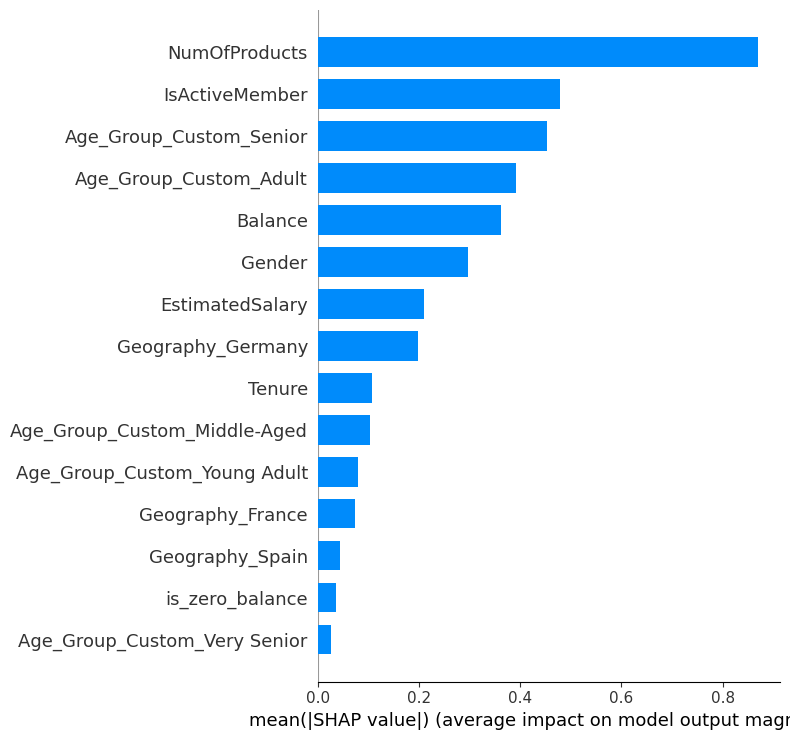

In [24]:
log_transform_cols  = ['EstimatedSalary', 'Balance']
one_hot_labels = ['Geography', 'Age_Group_Custom']
labels_endcode = ['Gender']
feature_names_after_onehot = cat_model.named_steps['preprocessor'].named_transformers_['onehot_encode']['onehot_encoder'].get_feature_names_out(input_features=one_hot_labels)
onehot_cols = list(feature_names_after_onehot)
# Get column names after transformation
original_columns = list(x_test.columns)
feature_names = (
    labels_endcode
    +onehot_cols
    + log_transform_cols
    + [col for col in original_columns if col not in labels_endcode + onehot_cols + log_transform_cols + one_hot_labels + ['Exited']]
)

# print(feature_names)
# feature_names = log_transform_cols +[col for col in input_data.columns if col not in log_transform_cols+['Exited']]
print(x_test.columns,print(x_test.shape))

print(cat_model.named_steps['preprocessor'].transform(x_test).shape)
print(len(feature_names))
print(feature_names)
X_test_processed = pd.DataFrame(cat_model.named_steps['preprocessor'].transform(x_test),columns=feature_names)

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(cat_model.named_steps["model"]) 
shap_values = explainer.shap_values(X_test_processed)

#     # SHAP Bar Plot
# st.subheader("SHAP Bar Plot")
# col1, col2 = st.columns([0.7, 0.3])  # Adjust column widths as needed
# with col1:
#     fig_bar = plt.figure()
shap.summary_plot(shap_values, X_test_processed, plot_type="bar", show=False)
    # st.pyplot(fig_bar)
